## 2. hingeLoss로 cnn 학습

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./diabetes.csv", index_col=None)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
X=df.drop('Outcome',axis=1)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [5]:
y=df['Outcome']
y.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [6]:
print(X.dtypes)
print(y.dtypes)

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object
int64


In [7]:
X = X.astype('float32')
y = y.astype('float32')

In [8]:
print(X.shape)
print(y.shape)

(768, 8)
(768,)


In [9]:
from sklearn.preprocessing import MinMaxScaler
# 2차원 상태에서 정규화를 진행
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

(768, 8, 1)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=0)

In [11]:
# Base 모델을 로드 (LA_Model.h5)
from tensorflow.keras.models import load_model

cnn_model = load_model('./models/cnn_model.h5')

In [12]:
# 기존 모델의 층을 동결 (학습되지 않도록 설정)
cnn_model.trainable = False

In [14]:
import tensorflow as tf
from tensorflow.keras import  models
from keras.layers import Conv1D, Flatten, Dense

def remove_last_layers(model, num_layers_to_remove):
    # 모델의 레이어를 하나씩 슬라이스해서 앞의 레이어만 가져옴
    model_layers = model.layers[:-num_layers_to_remove]  # 마지막 레이어부터 지정된 갯수만큼 제외
    return  models.Sequential(model_layers)  # 새로운 모델에 해당 레이어들만 추가

# 출력층부터 3개의 레이어를 삭제
new_model = remove_last_layers(cnn_model, 3)
new_model.add(Conv1D(32, 3, activation='relu', name='conv1d_2'))
new_model.add(Flatten())
new_model.add(Dense(100, activation='relu'))
new_model.add(Dense(1, activation='linear'))

# 모델 요약 출력
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 32)             6176      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 100)               3300      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                      

In [15]:
from tensorflow.keras.metrics import AUC
# Hinge loss를 사용하여 컴파일
new_model.compile(optimizer='adam', loss='hinge', metrics=['accuracy', AUC(name='auc')])

In [16]:
model_history=new_model.fit(x=X_train, y=y_train, epochs=30, batch_size=32,validation_data= (X_test,y_test))
y_pred = new_model.predict(X_test)

# 확률을 0.5 기준으로 0 또는 1로 변환 (이진 분류일 경우)
y_pred_class = (y_pred >= 0.5).astype(int)  # 0.5 이상이면 1, 아니면 0

# y_test를 numpy 배열로 변환하여 1차원 배열로 처리
y_test_class = y_test.to_numpy()  # 또는 y_test.values로도 변환 가능

# y_test_class와 y_pred_class의 차원을 출력해 확인
print("y_test_class shape:", y_test_class.shape)
print("y_pred_class shape:", y_pred_class.shape)

Epoch 1/30


2024-10-02 16:42:52.342825: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


18/18 [==============================] - 1s 11ms/step - loss: 0.9485 - accuracy: 0.6424 - auc: 0.5000 - val_loss: 0.8562 - val_accuracy: 0.6771 - val_auc: 0.5000
Epoch 2/30
18/18 [==============================] - 0s 2ms/step - loss: 0.8019 - accuracy: 0.6424 - auc: 0.5000 - val_loss: 0.6911 - val_accuracy: 0.6771 - val_auc: 0.5000
Epoch 3/30
18/18 [==============================] - 0s 2ms/step - loss: 0.7483 - accuracy: 0.6424 - auc: 0.5000 - val_loss: 0.6630 - val_accuracy: 0.6771 - val_auc: 0.5000
Epoch 4/30
18/18 [==============================] - 0s 2ms/step - loss: 0.7333 - accuracy: 0.6424 - auc: 0.5000 - val_loss: 0.6535 - val_accuracy: 0.6771 - val_auc: 0.5000
Epoch 5/30
18/18 [==============================] - 0s 2ms/step - loss: 0.7217 - accuracy: 0.6424 - auc: 0.5000 - val_loss: 0.6462 - val_accuracy: 0.6771 - val_auc: 0.5000
Epoch 6/30
18/18 [==============================] - 0s 2ms/step - loss: 0.7158 - accuracy: 0.6424 - auc: 0.5000 - val_loss: 0.6424 - val_accuracy: 0.6

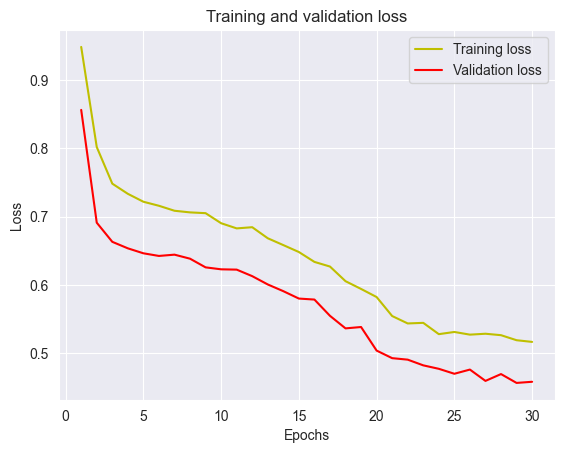

In [17]:
loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

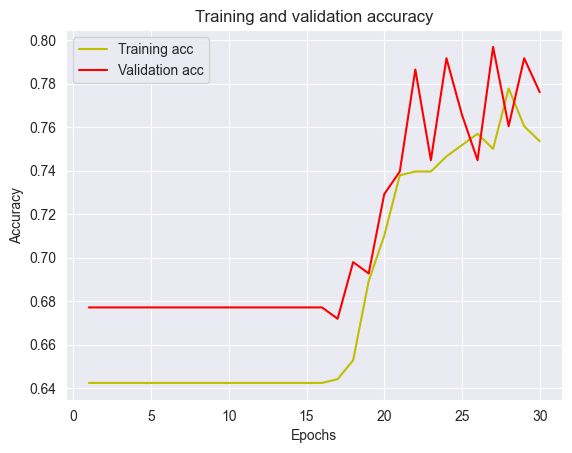

In [18]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

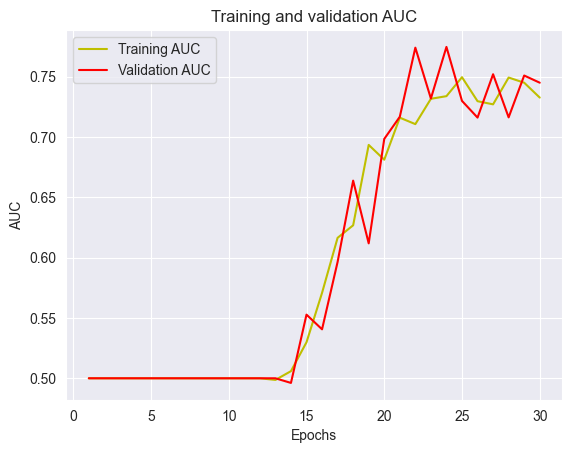

In [19]:
# 모델 학습 후의 history에서 'auc'와 'val_auc'를 추출
auc = model_history.history['auc']
val_auc = model_history.history['val_auc']

epochs = range(1, len(auc) + 1)

# AUC를 시각화
plt.plot(epochs, auc, 'y', label='Training AUC')
plt.plot(epochs, val_auc, 'r', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [20]:
model_file='./models/transfer_learning_cnn.h5'
  
tf.keras.models.save_model(new_model, model_file, include_optimizer=False)
print('model saved at ', model_file)

model saved at  ./models/transfer_learning_cnn.h5


In [21]:
#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class, zero_division=0))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

         0.0       0.77      0.95      0.85       130
         1.0       0.79      0.42      0.55        62

    accuracy                           0.78       192
   macro avg       0.78      0.68      0.70       192
weighted avg       0.78      0.78      0.75       192

[[123   7]
 [ 36  26]]
